In [1]:
using JuMP, Gurobi

Using Algorithm 1 from Parmentier et al. (2020), we get an RJT:

![Rooted Junction Tree of the N-monitoring problem](nmonitoring_rjt.png)


In [89]:
# Calculate the utility of the path
function profit(c,a,f,t,N)
    if f != t
        return 0
    else
        utility = sum(-c[k]*(a[k]-1) for k in 1:N)
        if f == 1 # No failure
            utility += 100 
        end
        return utility
    end
end

# Calculate probability of failure 
function p_fail(b,c,l,a,f,p_low,p_high)
    p = l==1 ? p_low : p_high
    prob_fail = p/exp(b*sum(c.*(a.-1)))
    if f == 1
        return 1-prob_fail
    else
        return prob_fail
    end
end

# A helper function for returning an array of possible paths (cartesian indices) 
# for nodes whose number of states is defined by the vector arr
function cart(arr)
    cart_arr = CartesianIndices(zeros(Tuple(arr)))
    index_arr = []
    for index in cart_arr
        push!(index_arr, [elem for elem in Tuple(index)])
    end
    return index_arr
end

function solve_nmonitoring(N; verbose=false)
    model = Model()
    if !verbose
        set_silent(model)
    end
    optimizer = optimizer_with_attributes(
        () -> Gurobi.Optimizer(Gurobi.Env()),
        "IntFeasTol"      => 1e-9,
        "TimeLimit"       => 3600,
        # "DualReductions"  => 0,
    )
    set_optimizer(model, optimizer)

    # Index sets
    L_set = 1:2 # Low / high
    R_set = 1:2 # Low / high
    A_set = 1:2 # Do nothing / fortify
    F_set = 1:2 # No failure / failure
    T_set = 1:2
    
    # Cardinality of index sets
    L = L_set[end] 
    R = R_set[end] 
    A = A_set[end] 
    F = F_set[end] 
    T = T_set[end]
    
    # fortification costs
    c_k = rand(N)
        
    # Load probabilities
    p_L = rand(2)
    p_L = p_L./sum(p_L) # probabilities sum to 1
    
    # Result probabilities
    p_res = zeros(L,N,R)
    for k in 1:N
        for l in L_set
            temp = rand(R)
            temp = temp./sum(temp)
            if l == 1 # Low load, low result should be more likely
                sort!(temp, rev=true)
            elseif l == 2
                sort!(temp) # High load, high result should be more likely
            end
            p_res[l,k,:] = temp
        end
    end
    
    # Probabilities/values related to failure
    x = rand()
    y = rand()
    p_low = min(y,1-y)
    p_high = max(x,1-x)
    b = 0.03
    
    # Variables corresponding to the nodes in the RJT
    @variable(model, μ_L[L_set] >= 0)
    
    vec_μ_R = Vector{Array{VariableRef}}(undef, N)
    for k in 1:N
        μ_R = Array{VariableRef}(undef, ([L, fill(R,k)...]...))
        for index in CartesianIndices(μ_R)
            μ_R[index] = @variable(model, base_name="μ_R[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_R[k] = μ_R
    end
    
    vec_μ_A = Vector{Array{VariableRef}}(undef, N)
    for k in 1:N
        μ_A = Array{VariableRef}(undef, ([L, fill(R,N-(k-1))..., fill(A,k)...]...))
        for index in CartesianIndices(μ_A)
            μ_A[index] = @variable(model, base_name="μ_A[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_A[k] = μ_A
    end
    
    μ_F = Array{VariableRef}(undef, ([L, fill(A,N)..., F]...))
    for index in CartesianIndices(μ_F)
        μ_F[index] = @variable(model, base_name="μ_F[$(join(Tuple(index),','))]", lower_bound=0)
    end
    
    μ_T = Array{VariableRef}(undef, ([fill(A,N)..., F, T]...))
    for index in CartesianIndices(μ_T)
        μ_T[index] = @variable(model, base_name="μ_T[$(join(Tuple(index),','))]", lower_bound=0)
    end
    
    # Decision strategy variable
    @variable(model, δ[1:N,R_set,A_set], Bin)

    # Objective function
    @objective(model, Max, sum(μ_T[a...,f,t]*profit(c_k,a,f,t,N) for f in F_set, t in T_set, a in cart([fill(A,N)...])))
    
    # Probability distributions μ sum to 1
    @constraint(model, sum(μ_L) == 1)
    @constraint(model, [k in 1:N], sum(vec_μ_R[k]) == 1)
    @constraint(model, [k in 1:N], sum(vec_μ_A[k]) == 1)
    @constraint(model, sum(μ_F) == 1)
    @constraint(model, sum(μ_T) == 1)

    # Local consistency constraints
    @constraint(model, [l in L_set], μ_L[l] == sum(vec_μ_R[1][l,r1] for r1 in R_set))
    @constraint(model, [l in L_set, k=2:N, r in cart(fill(R,k-1))], vec_μ_R[k-1][l,r...] == sum(vec_μ_R[k][l,r...,rk] for rk in R_set))
    @constraint(model, [l in L_set, r in cart(fill(R,N))], vec_μ_R[N][l,r...] == sum(vec_μ_A[1][l,r...,a1] for a1 in A_set))
    @constraint(model, [l in L_set, k=2:N, r in cart(fill(R,N-(k-1))), a in cart(fill(A,k-1))], sum(vec_μ_A[k-1][l,rk,r...,a...] for rk in R_set) == sum(vec_μ_A[k][l,r...,a...,ak] for ak in A_set))
    @constraint(model, [l in L_set, a in cart(fill(A,N))], sum(vec_μ_A[N][l,rn,a...] for rn in R_set) == sum(μ_F[l,a...,f] for f in F_set))
    @constraint(model, [a in cart(fill(A,N)), f in F_set], sum(μ_F[l,a...,f] for l in L_set) == sum(μ_T[a...,f,t] for t in T_set))
    
    # Moments μ_{\breve{C}_v} (the moments from above, but with the last variable dropped out)
    # Some such moments were already created
    vec_μ_A_br = Vector{Array{VariableRef}}(undef, N)
    for k in 2:N
        μ_A_br = Array{VariableRef}(undef, ([L, fill(R,N-(k-1))..., fill(A,k-1)...]...))
        for index in CartesianIndices(μ_A_br)
            μ_A_br[index] = @variable(model, base_name="μ_A_br[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_A_br[k] = μ_A_br
    end
    
    μ_F_br = Array{VariableRef}(undef, ([L, fill(A,N)...]...))
    for index in CartesianIndices(μ_F_br)
        μ_F_br[index] = @variable(model, base_name="μ_F_br[$(join(Tuple(index),','))]", lower_bound=0)
    end
    
    μ_T_br = Array{VariableRef}(undef, ([fill(A,N)..., F]...))
    for index in CartesianIndices(μ_T_br)
        μ_T_br[index] = @variable(model, base_name="μ_T_br[$(join(Tuple(index),','))]", lower_bound=0)
    end

    # μ_{\breve{C}_v} = ∑_{x_v} μ_{C_v}
    @constraint(model, [l in L_set, k=2:N, r in cart(fill(R,N-(k-1))), a in cart(fill(A,k-1))], vec_μ_A_br[k][l,r...,a...] == sum(vec_μ_A[k][l,r...,a...,ak] for ak in A_set))
    @constraint(model, [l in L_set, a in cart(fill(A,N))], μ_F_br[l,a...] == sum(μ_F[l,a...,f] for f in F_set))
    @constraint(model, [a in cart(fill(A,N)), f in F_set], μ_T_br[a...,f] == sum(μ_T[a...,f,t] for t in T_set))
    
    # Factorization constraints (Corollary 3 in Parmentier et al.)
    @constraint(model, [l in L_set], μ_L[l] == p_L[l])
    @constraint(model, [l in L_set, r1 in R_set], vec_μ_R[1][l,r1] == p_L[l]*p_res[l,1,r1])
    @constraint(model, [l in L_set, k in 2:N, r in cart(fill(R,k-1)), rk in R_set], vec_μ_R[k][l,r...,rk] == vec_μ_R[k-1][l,r...]*p_res[l,k,rk])
    @constraint(model, [l in L_set, r in cart(fill(R,N)), a1 in A_set], vec_μ_A[1][l,r...,a1] == vec_μ_R[N][l,r...]*δ[1,r[1],a1])
    @constraint(model, [l in L_set, k in 2:N, r in cart(fill(R,N-(k-1))), a in cart(fill(A,k-1)), ak in A_set], vec_μ_A[k][l,r...,a...,ak] == vec_μ_A_br[k][l,r...,a...]*δ[k,r[1],ak])
    @constraint(model, [l in L_set, a in cart(fill(A,N)), f in F_set], μ_F[l,a...,f] == μ_F_br[l,a...]*p_fail(b,c_k,l,a,f,p_low,p_high))
    @constraint(model, [a in cart(fill(A,N)), f in F_set, t in T_set], μ_T[a...,f,t] == μ_T_br[a...,f]*(f==t ? 1 : 0))
    
    
    optimize!(model)

    # solution_summary(model)
    
    return objective_value(model), value.(δ), solve_time(model)
end

solve_nmonitoring (generic function with 1 method)

In [90]:
N_arr = [1; 2; 3; 4; 5; 6; 7; 8; 9; 10]
sol_times = []
n_sample = 10
for N in N_arr
    println(N)
    total_time = 0
    for i in 1:n_sample
        _, _, t = solve_nmonitoring(N)
        total_time+=t
    end
    push!(sol_times, total_time/n_sample)
end

1
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.

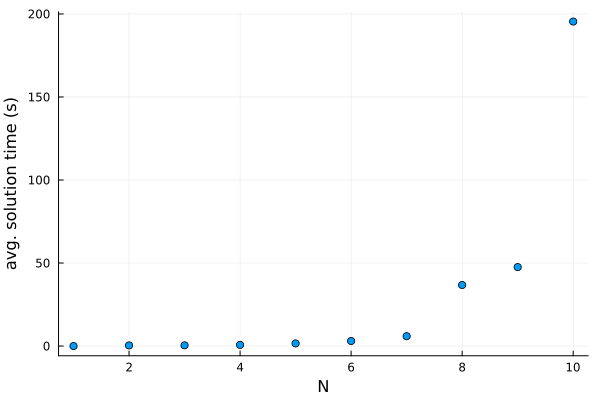

In [91]:
using Plots
scatter(N_arr, sol_times, xlabel="N", ylabel="avg. solution time (s)", label=false)